# Wikipedia Adminship Rights

- Ashish Bhat
- Humaid Desai
- Priyanka Savla

# Google colab requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("drive/MyDrive/SMA_AHP")
os.getcwd()

'/content/drive/MyDrive/SMA_AHP'

# Libraries

In [3]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression

import networkx as nx
import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

import subprocess
import shutil
import os
import os.path as osp
import pickle
from tqdm.auto import tqdm
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Construct the Wikipedia graph from the raw data

In [4]:
Wiki = nx.DiGraph()
index_dict = {}
index = 0

print("Constructing the Wikipedia graph...")
raw_path = osp.join(".", "data", "rfa_all.txt")
assert osp.exists(raw_path), IOError(f"{raw_path} does not exist!")

with open(raw_path, 'r') as ip:
    data, skip = [], False
    for line in ip:
        pre, suc = line[:3], line[4:]
        if pre in ["SRC", "TGT", "TXT"]:
            skip = (suc == "\n")
            data.append(suc)
        elif pre == "VOT":
            skip = (suc == "\n")
            data.append(int(suc))
        elif line == "\n":
            src, dst, v, txt = data
            if not skip and v != 0 and src != dst:
                if not src in index_dict:
                    index_dict[src] = index
                    index += 1
                if not dst in index_dict:
                    index_dict[dst] = index
                    index += 1
                Wiki.add_edge(str(index_dict[src]), str(index_dict[dst]),
                              vote = (float(v) != -1), text = txt)
            data, skip = [], False

print("Completed!")
print(f"\n{Wiki.number_of_nodes()} nodes with {Wiki.number_of_edges()} edges")
graph_path = osp.join(".", "data", "graph.pkl")
nx.write_gpickle(Wiki, graph_path)
print(f"Graph saved at {graph_path}")

Constructing the Wikipedia graph...
Completed!

11199 nodes with 172062 edges
Graph saved at ./data/graph.pkl


# Create the subgraphs from the Wikipedia graph

In [5]:
num_subs = 10
num_nodes = 200

print("Constructing subgraphs...")
assert osp.exists(graph_path), IOError(f"{graph_path} does not exist!")
Wiki = nx.read_gpickle(graph_path)

random_indices = np.random.choice(range(Wiki.number_of_nodes()), num_subs, 
                                  replace = False)
nodes_list = list(Wiki.nodes())
subs_list = []

for index in tqdm(random_indices):
    queue = [nodes_list[index]]
    list_nodes = []
    while len(list_nodes) <= num_nodes:
        nbrs = list(nx.all_neighbors(Wiki, queue.pop(0)))
        nbrs = [nbr for nbr in nbrs if nbr not in list_nodes]
        for nbr in nbrs:
            list_nodes.append(nbr)
            queue.append(nbr)
    subs_list.append(nx.DiGraph(Wiki.subgraph(list_nodes[:num_nodes])))

print("Completed!")
print(f"\n{num_subs} subgraphs with {num_nodes} nodes each")
subs_path = osp.join(".", "data", "subs_list.pkl")
pickle.dump(subs_list, open(subs_path, 'wb'))
print(f"Subgraphs saved at {subs_path}")

Constructing subgraphs...


  0%|          | 0/10 [00:00<?, ?it/s]

Completed!

10 subgraphs with 200 nodes each
Subgraphs saved at ./data/subs_list.pkl


# Create the training and test sets from these subgraphs

In [6]:
def get_tt_sets(train_sG, er = 1.0, verbose = False,
                subs_path = osp.join(".", "data", "subs_list.pkl")):
    print("Creating training and test sets...")
    assert osp.exists(subs_path), IOError(f"{subs_path} does not exist!")
    subs_list = pickle.load(open(subs_path, "rb"))

    orig_train_sG = subs_list[train_sG]
    orig_test_sG = subs_list[(train_sG + 1) % len(subs_list)]
    del_E = [E for E in orig_test_sG.edges() if E in orig_train_sG.edges()]
    orig_test_sG.remove_edges_from(del_E)
    
    train_sG = orig_train_sG.copy()
    test_sG = orig_test_sG.copy()

    print(f"Retain {er * 100}% of the evidence and discard the others")
    # Remove votes from training set
    num_train_E = train_sG.number_of_edges()
    indices_del_vote_train = np.random.choice(num_train_E, 
                                              int(num_train_E * (1 - er)),
                                              replace = False)
    num_del_vote_train = 0
    for i, E in enumerate(train_sG.edges()):
        if i in indices_del_vote_train:
            train_sG[E[0]][E[1]]['vote'] = None
            num_del_vote_train += 1

    # Remove votes from test set
    num_test_E = test_sG.number_of_edges()
    indices_del_vote_test = np.random.choice(num_test_E, 
                                              int(num_test_E * (1 - er)),
                                              replace = False)
    num_del_vote_test = 0
    for i, E in enumerate(test_sG.edges()):
        if i in indices_del_vote_test:
            test_sG[E[0]][E[1]]['vote'] = None
            num_del_vote_test += 1

    if verbose:
        print(f"Training edges: {num_train_E}")
        print(f"Testing edges: {num_test_E}")
        print(f"{len(del_E)} overlapping edges discarded")
        print(f"{num_del_vote_train} votes discarded from the training set")
        print(f"{num_del_vote_test} votes discarded from the testing set")

    return train_sG, test_sG, orig_train_sG, orig_test_sG

# Wikipedia corpus model

In [7]:
from collections import Counter
def comms_tokenizer(txt, drop_feats = []):
    blacklist = ["over", "only", "very", "not", "no"]
    english = set(stopwords.words("english")) - set(blacklist)
    neg = [
            (r'aren\'t', 'are not'),
            (r'can\'t', 'can not'),
            (r'couldn\'t', 'could not'),
            (r'daren\'t', 'dare not'),
            (r'didn\'t', 'did not'),
            (r'doesn\'t', 'does not'),
            (r'don\'t', 'do not'),
            (r'isn\'t', 'is not'),
            (r'hasn\'t', 'has not'),
            (r'haven\'t', 'have not'),
            (r'hadn\'t', 'had not'),
            (r'mayn\'t', 'may not'),
            (r'mightn\'t', 'might not'),
            (r'mustn\'t', 'must not'),
            (r'needn\'t', 'need not'),
            (r'oughtn\'t', 'ought not'),
            (r'shan\'t', 'shall not'),
            (r'shouldn\'t', 'should not'),
            (r'wasn\'t', 'was not'),
            (r'weren\'t', 'were not'),
            (r'won\'t', 'will not'),
            (r'wouldn\'t', 'would not'),
            (r'ain\'t', 'am not')
    ]
    other = {
             "'m": 'am',
            "'ll": 'will',
            "'s": 'has',
            "'d": 'had'
    }

    #txt = txt.decode('utf-8')
    txt = txt.lower()
    for t in neg:
        txt = re.sub(t[0], t[1], txt)
    tokens = word_tokenize(txt)
    tokens = [other[token] if other.get(token) else token for token in tokens]
    tokens = [word for word in tokens if re.search(r'[a-z]+', word)]
    tokens = [token for token in tokens if token not in english]
    tokens = [PorterStemmer().stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in ['support', 'oppos']]
    tokens = [token for token in tokens if token not in drop_feats]

    return tokens


class SentimentClassifier(object):
    def __init__(self, 
                 graph_path = osp.join(".", "data", "graph.pkl")):
        assert osp.exists(graph_path), \
            IOError(f"{graph_path} does not exist!")
        self.graph_path = graph_path
        self.model = None
        self.vec = None
        self.sort_feats = None
        self.num_drop_feats = 0

    def set_num_drop_feats(self, num_drop_feats):
        self.num_drop_feats = num_drop_feats
        print(f"Drop the top {num_drop_feats} features (based on MI) from comments")

    def verify_comms(self, comms):
        assert isinstance(comms, list), \
            TypeError(f"Expected list, got {type(comms)} instead")
        drop_feats = self.sort_feats[:self.num_drop_feats]
        vecs_stitch = [' '.join(comms_tokenizer(comm, drop_feats = drop_feats)) \
                       for comm in comms]
        return self.vec.transform(vecs_stitch)
        
    def score(self, comms, votes):
        return self.model.score(self.verify_comms(comms), votes)

    def predict(self, comms, num_drop_feats = 0):
        return list(self.model.predict(self.verify_comms(comms)))

    def predict_proba(self, comms, num_drop_feats = 0):
        return list(self.model.predict_proba(self.verify_comms(comms)))
        
    def get_Wiki_corpus_model(self):
        clf_path = osp.join(".", "models", "sentimentClassifier.pkl")
        if osp.exists(clf_path):
            clf = pickle.load(open(clf_path, "rb"))
            print("Sentiment classifier loaded!")
            self.vec = clf.vec
            self.model = clf.model
            self.sort_feats = clf.sort_feats
        else:
            print("Creating sentiment classifier...")
            Wiki = pickle.load(open(self.graph_path, 'rb'))
            E = Wiki.edges(data = True)
            comms, votes = [], []
            for e in E:
                comms.append(e[2]['text'])
                votes.append(e[2]['vote'])
            
            # Remove empty comments
            size_comms = len(comms)
            for i in range(size_comms - 1, -1, -1):
                if len(comms_tokenizer(comms[i])) == 0:
                    del votes[i]
                    del comms[i]

            fdist = FreqDist([word for comm in comms \
                              for word in comms_tokenizer(comm)])
            feats = fdist.most_common(10000)
            feats = [feat[0] for feat in feats]
            print("10000 most common words were selected as features")

            index_sample_comms = np.random.choice(len(comms), 1000, 
                                                  replace = False)
            sample_comms, sample_votes = [], []
            for index in index_sample_comms:
                sample_comms.append(comms[index])
                sample_votes.append(votes[index])
            ctr = Counter(sample_votes)
            print(f"Sample comments with {ctr[1]} upvotes and {ctr[-1]} downvotes")

            vec = CountVectorizer(vocabulary = feats)
            X = vec.transform([' '.join(comms_tokenizer(comm)) \
                               for comm in sample_comms])
            y = sample_votes
            lr = LogisticRegression(class_weight = "balanced")
            lr.fit(X, y)
            print(f"Logistic regression has training set precision: {lr.score(X, y)}")

            MI = mutual_info_classif(X, y)
            sort_feats = [feat for feat, _ in sorted(zip(feats, MI), 
                                                     key = lambda pair: pair[1], 
                                                     reverse = True)]
            print("Features have been sorted based on MI")
            
            print("Completed!")
            self.sort_feats = sort_feats
            self.model = lr
            self.vec = vec
            pickle.dump(self, open(clf_path, 'wb'))
            print(f"Classifier saved at {clf_path}")

# Wikipedia ROC-AUC, average precision for varying evidence ratio

In [8]:
er_list = [0.125, 0.25, 0.5, 0.75]
df_er = pd.DataFrame(columns = ["ER", "Model", "ROC-AUC", "Avg Prec"])
for er in er_list:
    for i in tqdm(range(10)):
        train_G, test_G, orig_train_G, orig_test_G = get_tt_sets(i, er)

        # Random model
        y_rand = []
        for E in test_G.edges(data = True):
            if E[2]["vote"] == None:
                y_rand.append(orig_test_G[E[0]][E[1]]["vote"])
        y_rand_hat = np.random.rand(len(y_rand))
        rand_auc = roc_auc_score(y_rand, y_rand_hat)
        rand_prec = average_precision_score([1-i for i in y_rand], 
                                           [1-i for i in y_rand_hat])
        df_er.loc[len(df_er)] = [er, "Random", rand_auc, rand_prec]
        print("\nRandom model:")
        print(f"ROC-AUC: {rand_auc}")
        print(f"Precision (average): {rand_prec}\n")

        # Sentiment model
        clf = SentimentClassifier()
        clf.get_Wiki_corpus_model()
        X_sent, y_sent = [], []
        for E in test_G.edges(data = True):
            if E[2]["vote"] == None:
                X_sent.append(E[2]["text"])
                y_sent.append(orig_test_G[E[0]][E[1]]["vote"])
        y_sent_hat = clf.predict_proba(X_sent)
        y_sent_hat = [pred[1] for pred in y_sent_hat]
        sent_auc = roc_auc_score(y_sent, y_sent_hat)
        sent_prec = average_precision_score([1-i for i in y_sent], 
                                           [1-i for i in y_sent_hat])
        df_er.loc[len(df_er)] = [er, "Sentiment", sent_auc, sent_prec]
        print("\nSentiment model:")
        print(f"ROC-AUC: {sent_auc}")
        print(f"Precision (average): {sent_prec}\n")

        # Network model
        test_E = {}
        wiki_knows_obs_path = osp.join(".", "wikipedia_knows_obs.txt")
        wiki_trusts_obs_path = osp.join(".", "wikipedia_trusts_obs.txt")
        wiki_trusts_tgts_path = osp.join(".", "wikipedia_trusts_targets.txt")

        with open(wiki_knows_obs_path, 'w') as knows_obs:
            with open(wiki_trusts_obs_path, 'w') as trusts_obs:
                with open(wiki_trusts_tgts_path, 'w') as trusts_tgts:
                    w_knows_obs = csv.writer(knows_obs, delimiter="\t")
                    w_trusts_obs = csv.writer(trusts_obs, delimiter = "\t")
                    w_trusts_tgts = csv.writer(trusts_tgts, delimiter = "\t")
                    for E in list(test_G.edges(data = True)):
                        w_knows_obs.writerow([E[0], E[1]])
                        if E[2]["vote"] != None:
                            w_trusts_obs.writerow([E[0], E[1], float(E[2]["vote"])])
                        else:
                            w_trusts_tgts.writerow([E[0], E[1]])
                            test_E[tuple([E[0], 
                                          E[1]])] = float(orig_test_G[E[0]][E[1]]["vote"])
        
        if osp.exists(osp.join('.', 'inferred-predicates')):
            shutil.rmtree(osp.join('.', 'inferred-predicates'))
        process = subprocess.Popen('java -jar psl-cli-2.2.1.jar --model wikipedia_network_model.psl --data wikipedia_network_model.data --output inferred-predicates --infer --eval org.linqs.psl.evaluation.statistics.DiscreteEvaluator "$@"',
                                   shell = True)
        while not osp.exists(osp.join('.', 'inferred-predicates')):
            process.wait()

        y_net, y_net_hat = [], []
        res_path = osp.join('.', 'inferred-predicates', 'TRUSTS.txt')
        assert osp.exists(res_path), IOError(f"{res_path} does not exist!")
        with open(res_path, 'r') as ip:
            for line in ip:
                src, dst, vote = line.split()
                E = [src, dst]
                vote = float(vote)
                if tuple(E) in test_E:
                    y_net.append(test_E[tuple(E)])
                    y_net_hat.append(vote)
    
        assert len(y_net) > 0, ValueError('No predictions made')

        net_auc = roc_auc_score(y_net, y_net_hat)
        net_prec = average_precision_score([1-i for i in y_net], 
                                           [1-i for i in y_net_hat])
        df_er.loc[len(df_er)] = [er, "Network", net_auc, net_prec]
        print("\nNetwork model:")
        print(f"ROC-AUC: {net_auc}")
        print(f"Precision (average): {net_prec}\n")

        # Combined model
        clf = SentimentClassifier()
        clf.get_Wiki_corpus_model()

        test_E = {}
        wiki_comb_prior_obs_path = osp.join(".", "wikipedia_comb_prior_obs.txt")
        wiki_comb_knows_obs_path = osp.join(".", "wikipedia_comb_knows_obs.txt")
        wiki_comb_trusts_obs_path = osp.join(".", "wikipedia_comb_trusts_obs.txt")
        wiki_comb_trusts_tgts_path = osp.join(".", "wikipedia_comb_trusts_targets.txt")

        with open(wiki_comb_prior_obs_path, 'w') as comb_prior_obs:
            with open(wiki_comb_knows_obs_path, 'w') as comb_knows_obs:
                with open(wiki_comb_trusts_obs_path, 'w') as comb_trusts_obs:
                    with open(wiki_comb_trusts_tgts_path, 'w') as comb_trusts_tgts:
                        comb_w_prior_obs = csv.writer(comb_prior_obs, delimiter="\t")
                        comb_w_knows_obs = csv.writer(comb_knows_obs, delimiter="\t")
                        comb_w_trusts_obs = csv.writer(comb_trusts_obs, delimiter = "\t")
                        comb_w_trusts_tgts = csv.writer(comb_trusts_tgts, delimiter = "\t")
                        for E in list(test_G.edges(data = True)):
                            comb_w_prior_obs.writerow([E[0], E[1], 
                                                  clf.predict_proba([E[2]['text']])[0][1]])
                            comb_w_knows_obs.writerow([E[0], E[1]])
                            if E[2]['vote'] != None:
                                comb_w_trusts_obs.writerow([E[0], E[1], float(E[2]['vote'])])
                            else:
                                comb_w_trusts_tgts.writerow([E[0], E[1]])
                                test_E[tuple([E[0], E[1]])] = float(orig_test_G[E[0]][E[1]]['vote'])

        if osp.exists(osp.join('.', 'comb-inferred-predicates')):
            shutil.rmtree(osp.join('.', 'comb-inferred-predicates'))
        process = subprocess.Popen('java -jar psl-cli-2.2.1.jar --model wikipedia_network_sentiment_model.psl --data wikipedia_network_sentiment_model.data --output comb-inferred-predicates --infer --eval org.linqs.psl.evaluation.statistics.DiscreteEvaluator "$@"',
                                   shell = True)
        while not osp.exists(osp.join('.', 'comb-inferred-predicates')):
            process.wait()

        y_comb, y_comb_hat = [], []
        res_path = osp.join('.', 'comb-inferred-predicates', 'TRUSTS.txt')
        assert osp.exists(res_path), IOError(f"{res_path} does not exist!")
        with open(res_path, 'r') as ip:
            for line in ip:
                src, dst, vote = line.split()
                E = [src, dst]
                vote = float(vote)
                if tuple(E) in test_E:
                    y_comb.append(test_E[tuple(E)])
                    y_comb_hat.append(vote)
    
        assert len(y_comb) > 0, ValueError('No predictions made')

        comb_auc = roc_auc_score(y_comb, y_comb_hat)
        comb_prec = average_precision_score([1-i for i in y_comb], 
                                           [1-i for i in y_comb_hat])
        df_er.loc[len(df_er)] = [er, "Combined", comb_auc, comb_prec]
        print("\nCombined model:")
        print(f"ROC-AUC: {comb_auc}")
        print(f"Precision (average): {comb_prec}\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 12.5% of the evidence and discard the others

Random model:
ROC-AUC: 0.5207346189164371
Precision (average): 0.15800913641100622

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8520390047662776
Precision (average): 0.5884454338927125


Network model:
ROC-AUC: 0.550710568892387
Precision (average): 0.17004286846266836

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.7475420875420875
Precision (average): 0.4041290383873074

Creating training and test sets...
Retain 12.5% of the evidence and discard the others

Random model:
ROC-AUC: 0.5101021192489293
Precision (average): 0.13295804295910044

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8828568433872046
Precision (average): 0.6033747626163098


Network model:
ROC-AUC: 0.5999970053006178
Precision (average): 0.23022453707025556

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.8259380895814409
Precision (average): 0.5450487173649701

Creating training and t

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 25.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5204313932360354
Precision (average): 0.16361968994735562

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8516851298282633
Precision (average): 0.6006220249343216


Network model:
ROC-AUC: 0.5635683723111189
Precision (average): 0.19547641165610527

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.781057382333978
Precision (average): 0.4480400523844761

Creating training and test sets...
Retain 25.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.49044229600098993
Precision (average): 0.13784356776903184

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8815314115703903
Precision (average): 0.5937583876175707


Network model:
ROC-AUC: 0.6625751193031728
Precision (average): 0.30931492426660484

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.8647778566855506
Precision (average): 0.59392023748048

Creating training and te

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 50.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.47304772522163824
Precision (average): 0.13645184190250922

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8551574029834901
Precision (average): 0.5916467799047163


Network model:
ROC-AUC: 0.6473217603652386
Precision (average): 0.2611344971755445

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.8294526729309338
Precision (average): 0.5101870173152723

Creating training and test sets...
Retain 50.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5218099782733295
Precision (average): 0.12321697277858565

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.9030264052357277
Precision (average): 0.6438153145356104


Network model:
ROC-AUC: 0.7412026978393293
Precision (average): 0.3246969457993588

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.9059888300921051
Precision (average): 0.666720195586035

Creating training and te

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.4982954545454546
Precision (average): 0.1619885191506189

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8590909090909091
Precision (average): 0.5753132486866612


Network model:
ROC-AUC: 0.6521416083916084
Precision (average): 0.23482453192150093

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.8448208041958042
Precision (average): 0.484135344734067

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.4999363381716323
Precision (average): 0.1340432783764043

Sentiment classifier loaded!

Sentiment model:
ROC-AUC: 0.8845429080723198
Precision (average): 0.615560669203754


Network model:
ROC-AUC: 0.7782021899668958
Precision (average): 0.38384088781178943

Sentiment classifier loaded!

Combined model:
ROC-AUC: 0.8998344792462439
Precision (average): 0.6229897891864331

Creating training and test

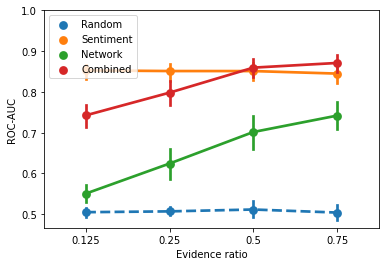

In [13]:
sns.pointplot(x = 'ER', y = 'ROC-AUC', hue = 'Model', data = df_er, 
              linestyles = ['--','-','-','-'], markers = ['o','o','o','o'], 
              ci = 95)
plt.legend(loc = 'upper left')
plt.ylim(ymax = 1)
plt.xlabel("Evidence ratio")
plt.savefig(osp.join('.', 'results', 'wikipedia_AUC_ROC_evidence_ratio.png'))
plt.show()

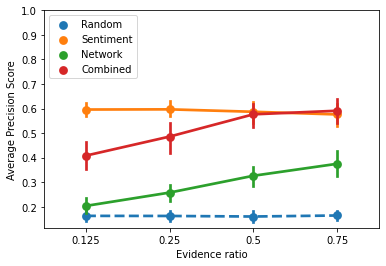

In [14]:
sns.pointplot(x = 'ER', y = 'Avg Prec', hue = 'Model', data = df_er, 
              linestyles = ['--','-','-','-'], markers = ['o','o','o','o'], 
              ci = 95)
plt.legend(loc = 'upper left')
plt.ylim(ymax = 1)
plt.xlabel("Evidence ratio")
plt.ylabel("Average Precision Score")
plt.savefig(osp.join('.', 'results', 'wikipedia_AUC_negPr_evidence_ratio.png'))
plt.show()

# Wikipedia ROC-AUC, average precision for varying number of dropped features

In [9]:
ndf_list = [0, 10, 50, 100, 500, 1000, 1500, 2000]
df_ndf = pd.DataFrame(columns = ["# dropped features", "Model", "ROC-AUC", "Avg Prec"])
for ndf in ndf_list:
    for i in tqdm(range(10)):
        train_G, test_G, orig_train_G, orig_test_G = get_tt_sets(i, 0.75)

        # Random model
        y_rand = []
        for E in test_G.edges(data = True):
            if E[2]["vote"] == None:
                y_rand.append(orig_test_G[E[0]][E[1]]["vote"])
        y_rand_hat = np.random.rand(len(y_rand))
        rand_auc = roc_auc_score(y_rand, y_rand_hat)
        rand_prec = average_precision_score([1-i for i in y_rand], 
                                           [1-i for i in y_rand_hat])
        df_ndf.loc[len(df_ndf)] = [ndf, "Random", rand_auc, rand_prec]
        print("\nRandom model:")
        print(f"ROC-AUC: {rand_auc}")
        print(f"Precision (average): {rand_prec}\n")

        # Sentiment model
        clf = SentimentClassifier()
        clf.get_Wiki_corpus_model()
        clf.set_num_drop_feats(ndf)
        X_sent, y_sent = [], []
        for E in test_G.edges(data = True):
            if E[2]["vote"] == None:
                X_sent.append(E[2]["text"])
                y_sent.append(orig_test_G[E[0]][E[1]]["vote"])
        y_sent_hat = clf.predict_proba(X_sent)
        y_sent_hat = [pred[1] for pred in y_sent_hat]
        sent_auc = roc_auc_score(y_sent, y_sent_hat)
        sent_prec = average_precision_score([1-i for i in y_sent], 
                                           [1-i for i in y_sent_hat])
        df_ndf.loc[len(df_ndf)] = [ndf, "Sentiment", sent_auc, sent_prec]
        print("\nSentiment model:")
        print(f"ROC-AUC: {sent_auc}")
        print(f"Precision (average): {sent_prec}\n")

        # Network model
        test_E = {}
        wiki_knows_obs_path = osp.join(".", "wikipedia_knows_obs.txt")
        wiki_trusts_obs_path = osp.join(".", "wikipedia_trusts_obs.txt")
        wiki_trusts_tgts_path = osp.join(".", "wikipedia_trusts_targets.txt")

        with open(wiki_knows_obs_path, 'w') as knows_obs:
            with open(wiki_trusts_obs_path, 'w') as trusts_obs:
                with open(wiki_trusts_tgts_path, 'w') as trusts_tgts:
                    w_knows_obs = csv.writer(knows_obs, delimiter="\t")
                    w_trusts_obs = csv.writer(trusts_obs, delimiter = "\t")
                    w_trusts_tgts = csv.writer(trusts_tgts, delimiter = "\t")
                    for E in list(test_G.edges(data = True)):
                        w_knows_obs.writerow([E[0], E[1]])
                        if E[2]["vote"] != None:
                            w_trusts_obs.writerow([E[0], E[1], float(E[2]["vote"])])
                        else:
                            w_trusts_tgts.writerow([E[0], E[1]])
                            test_E[tuple([E[0], 
                                          E[1]])] = float(orig_test_G[E[0]][E[1]]["vote"])
        
        if osp.exists(osp.join('.', 'inferred-predicates')):
            shutil.rmtree(osp.join('.', 'inferred-predicates'))
        process = subprocess.Popen('java -jar psl-cli-2.2.1.jar --model wikipedia_network_model.psl --data wikipedia_network_model.data --output inferred-predicates --infer --eval org.linqs.psl.evaluation.statistics.DiscreteEvaluator "$@"',
                                   shell = True)
        while not osp.exists(osp.join('.', 'inferred-predicates')):
            process.wait()

        y_net, y_net_hat = [], []
        res_path = osp.join('.', 'inferred-predicates', 'TRUSTS.txt')
        assert osp.exists(res_path), IOError(f"{res_path} does not exist!")
        with open(res_path, 'r') as ip:
            for line in ip:
                src, dst, vote = line.split()
                E = [src, dst]
                vote = float(vote)
                if tuple(E) in test_E:
                    y_net.append(test_E[tuple(E)])
                    y_net_hat.append(vote)
    
        assert len(y_net) > 0, ValueError('No predictions made')

        net_auc = roc_auc_score(y_net, y_net_hat)
        net_prec = average_precision_score([1-i for i in y_net], 
                                           [1-i for i in y_net_hat])
        df_ndf.loc[len(df_ndf)] = [ndf, "Network", net_auc, net_prec]
        print("\nNetwork model:")
        print(f"ROC-AUC: {net_auc}")
        print(f"Precision (average): {net_prec}\n")

        # Combined model
        clf = SentimentClassifier()
        clf.get_Wiki_corpus_model()
        clf.set_num_drop_feats(ndf)

        test_E = {}
        wiki_comb_prior_obs_path = osp.join(".", "wikipedia_comb_prior_obs.txt")
        wiki_comb_knows_obs_path = osp.join(".", "wikipedia_comb_knows_obs.txt")
        wiki_comb_trusts_obs_path = osp.join(".", "wikipedia_comb_trusts_obs.txt")
        wiki_comb_trusts_tgts_path = osp.join(".", "wikipedia_comb_trusts_targets.txt")

        with open(wiki_comb_prior_obs_path, 'w') as comb_prior_obs:
            with open(wiki_comb_knows_obs_path, 'w') as comb_knows_obs:
                with open(wiki_comb_trusts_obs_path, 'w') as comb_trusts_obs:
                    with open(wiki_comb_trusts_tgts_path, 'w') as comb_trusts_tgts:
                        comb_w_prior_obs = csv.writer(comb_prior_obs, delimiter="\t")
                        comb_w_knows_obs = csv.writer(comb_knows_obs, delimiter="\t")
                        comb_w_trusts_obs = csv.writer(comb_trusts_obs, delimiter = "\t")
                        comb_w_trusts_tgts = csv.writer(comb_trusts_tgts, delimiter = "\t")
                        for E in list(test_G.edges(data = True)):
                            comb_w_prior_obs.writerow([E[0], E[1], 
                                                  clf.predict_proba([E[2]['text']])[0][1]])
                            comb_w_knows_obs.writerow([E[0], E[1]])
                            if E[2]['vote'] != None:
                                comb_w_trusts_obs.writerow([E[0], E[1], float(E[2]['vote'])])
                            else:
                                comb_w_trusts_tgts.writerow([E[0], E[1]])
                                test_E[tuple([E[0], E[1]])] = float(orig_test_G[E[0]][E[1]]['vote'])

        if osp.exists(osp.join('.', 'comb-inferred-predicates')):
            shutil.rmtree(osp.join('.', 'comb-inferred-predicates'))
        process = subprocess.Popen('java -jar psl-cli-2.2.1.jar --model wikipedia_network_sentiment_model.psl --data wikipedia_network_sentiment_model.data --output comb-inferred-predicates --infer --eval org.linqs.psl.evaluation.statistics.DiscreteEvaluator "$@"',
                                   shell = True)
        while not osp.exists(osp.join('.', 'comb-inferred-predicates')):
            process.wait()

        y_comb, y_comb_hat = [], []
        res_path = osp.join('.', 'comb-inferred-predicates', 'TRUSTS.txt')
        assert osp.exists(res_path), IOError(f"{res_path} does not exist!")
        with open(res_path, 'r') as ip:
            for line in ip:
                src, dst, vote = line.split()
                E = [src, dst]
                vote = float(vote)
                if tuple(E) in test_E:
                    y_comb.append(test_E[tuple(E)])
                    y_comb_hat.append(vote)
    
        assert len(y_comb) > 0, ValueError('No predictions made')

        comb_auc = roc_auc_score(y_comb, y_comb_hat)
        comb_prec = average_precision_score([1-i for i in y_comb], 
                                           [1-i for i in y_comb_hat])
        df_ndf.loc[len(df_ndf)] = [ndf, "Combined", comb_auc, comb_prec]
        print("\nCombined model:")
        print(f"ROC-AUC: {comb_auc}")
        print(f"Precision (average): {comb_prec}\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.504232426230218
Precision (average): 0.14541514351985343

Sentiment classifier loaded!
Drop the top 0 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.8619211534714555
Precision (average): 0.6108761539277049


Network model:
ROC-AUC: 0.6891494013985409
Precision (average): 0.3458786481937455

Sentiment classifier loaded!
Drop the top 0 features (based on MI) from comments

Combined model:
ROC-AUC: 0.8706241475612132
Precision (average): 0.5517133163553342

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.476340320202233
Precision (average): 0.12808808195940258

Sentiment classifier loaded!
Drop the top 0 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.8946110701495681
Precision (average): 0.6335271809344697


Network model:
ROC-AUC: 0.794356962291974
Precision (average): 0.4156

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.47180186616440434
Precision (average): 0.1401405110288424

Sentiment classifier loaded!
Drop the top 10 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.7014245199281245
Precision (average): 0.3569233614304197


Network model:
ROC-AUC: 0.6679439717693924
Precision (average): 0.2996967104914802

Sentiment classifier loaded!
Drop the top 10 features (based on MI) from comments

Combined model:
ROC-AUC: 0.7387586326340629
Precision (average): 0.3708884312912742

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5163228927934811
Precision (average): 0.12912153722344588

Sentiment classifier loaded!
Drop the top 10 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.7784122740005094
Precision (average): 0.5091666421339205


Network model:
ROC-AUC: 0.7401069518716579
Precision (average): 

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.47781112444977997
Precision (average): 0.1644282826409379

Sentiment classifier loaded!
Drop the top 50 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.6219487795118047
Precision (average): 0.32216642614146707


Network model:
ROC-AUC: 0.7146958783513406
Precision (average): 0.32416337882810764

Sentiment classifier loaded!
Drop the top 50 features (based on MI) from comments

Combined model:
ROC-AUC: 0.7240796318527412
Precision (average): 0.400460703651432

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5302069425901201
Precision (average): 0.122585151915356

Sentiment classifier loaded!
Drop the top 50 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.6574792030399507
Precision (average): 0.2985352714744307


Network model:
ROC-AUC: 0.7751553353188867
Precision (average): 0

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5396596721996033
Precision (average): 0.17062445012812405

Sentiment classifier loaded!
Drop the top 100 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.6063263388662699
Precision (average): 0.314612274576978


Network model:
ROC-AUC: 0.6737133312454326
Precision (average): 0.28322114964027867

Sentiment classifier loaded!
Drop the top 100 features (based on MI) from comments

Combined model:
ROC-AUC: 0.716744962939764
Precision (average): 0.34858603435812685

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5223932129821446
Precision (average): 0.14869409982106685

Sentiment classifier loaded!
Drop the top 100 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.5851829929959554
Precision (average): 0.25088834875917104


Network model:
ROC-AUC: 0.8239987175693005
Precision (averag

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5054697554697555
Precision (average): 0.16132948395540103

Sentiment classifier loaded!
Drop the top 500 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.5005469755469756
Precision (average): 0.20772417666292556


Network model:
ROC-AUC: 0.6844165594165594
Precision (average): 0.29048651763162714

Sentiment classifier loaded!
Drop the top 500 features (based on MI) from comments

Combined model:
ROC-AUC: 0.6807807807807807
Precision (average): 0.26669322775633103

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5054997369146351
Precision (average): 0.1307021250906349

Sentiment classifier loaded!
Drop the top 500 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.530373831775701
Precision (average): 0.2396677850987915


Network model:
ROC-AUC: 0.7811756157450327
Precision (averag

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.48667282240689447
Precision (average): 0.15481444986940812

Sentiment classifier loaded!
Drop the top 1000 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.4992100133374372
Precision (average): 0.21311358309649628


Network model:
ROC-AUC: 0.6698779111521495
Precision (average): 0.3048376007837631

Sentiment classifier loaded!
Drop the top 1000 features (based on MI) from comments

Combined model:
ROC-AUC: 0.6565507335590437
Precision (average): 0.2918395191521941

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5294655608729423
Precision (average): 0.14190976332510852

Sentiment classifier loaded!
Drop the top 1000 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.5951993184836262
Precision (average): 0.2779228419638358


Network model:
ROC-AUC: 0.7512152038285185
Precision (av

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.5045688545688546
Precision (average): 0.17460305322468167

Sentiment classifier loaded!
Drop the top 1500 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.4829257829257829
Precision (average): 0.26159648235497585


Network model:
ROC-AUC: 0.6839339339339339
Precision (average): 0.28806795510433475

Sentiment classifier loaded!
Drop the top 1500 features (based on MI) from comments

Combined model:
ROC-AUC: 0.6614757614757615
Precision (average): 0.3117445609223599

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.49303720827829156
Precision (average): 0.12035851940545453

Sentiment classifier loaded!
Drop the top 1500 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.506130284015852
Precision (average): 0.2015073852048453


Network model:
ROC-AUC: 0.7760485468956407
Precision (av

  0%|          | 0/10 [00:00<?, ?it/s]

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.47005232379193596
Precision (average): 0.15010046004578842

Sentiment classifier loaded!
Drop the top 2000 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.4838411819021237
Precision (average): 0.23079151789625027


Network model:
ROC-AUC: 0.6558530829998974
Precision (average): 0.3110465723259737

Sentiment classifier loaded!
Drop the top 2000 features (based on MI) from comments

Combined model:
ROC-AUC: 0.6715091823125064
Precision (average): 0.3569491373400166

Creating training and test sets...
Retain 75.0% of the evidence and discard the others

Random model:
ROC-AUC: 0.527451980282169
Precision (average): 0.15323100828859043

Sentiment classifier loaded!
Drop the top 2000 features (based on MI) from comments

Sentiment model:
ROC-AUC: 0.5424285471455282
Precision (average): 0.2690551967200121


Network model:
ROC-AUC: 0.7905891066268427
Precision (ave

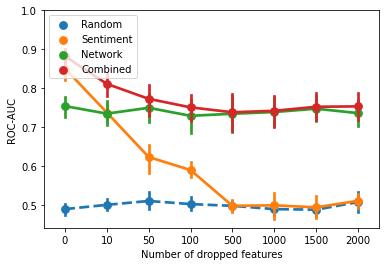

In [15]:
sns.pointplot(x = '# dropped features', y = 'ROC-AUC', hue = 'Model', 
              data = df_ndf,  linestyles = ['--','-','-','-'], 
              markers = ['o','o','o','o'], ci = 95)
plt.legend(loc='upper left')
plt.ylim(ymax = 1)
plt.xlabel("Number of dropped features")
plt.ylabel("ROC-AUC")
plt.savefig(osp.join('.', 'results', 
                     'wikipedia_AUC_ROC_number_dropped_features.png'))

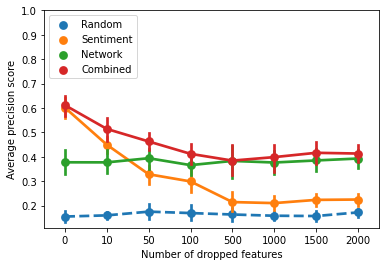

In [17]:
sns.pointplot(x = '# dropped features', y = 'Avg Prec', hue = 'Model', 
              data = df_ndf, linestyles = ['--','-','-','-'], 
              markers = ['o','o','o','o'], ci = 95)
plt.legend(loc='upper left')
plt.ylim(ymax = 1)
plt.xlabel("Number of dropped features")
plt.ylabel("Average precision score")
plt.savefig(osp.join('.', 'results', 
                     'wikipedia_AUC_negPR_number_dropped_features.png'))